In [44]:
from pathlib import Path
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from typing import Union
sns.set_theme('paper')

In [2]:
MERGED_LOAD_DIR = Path(
    Path.cwd().parent, "data.nosync", "transformed_data", "merged.parquet"
)

In [5]:
df = pd.read_parquet(MERGED_LOAD_DIR)
df.head()

,Time Stamp,Name,PTID,Load,Year,Month,Day,Minute,Hour,Max Temp,Min Temp,Max Wet Bulb,Min Wet Bulb
0,2016-06-22 00:00:00,CAPITL,61757.0,1252.099976,2016,6,22,0,0,27.777778,15.0,18.444444,11.777778
1,2016-06-22 00:05:00,CAPITL,61757.0,1239.199951,2016,6,22,5,0,27.777778,15.0,18.444444,11.777778
2,2016-06-22 00:10:00,CAPITL,61757.0,1241.900024,2016,6,22,10,0,27.777778,15.0,18.444444,11.777778
3,2016-06-22 00:15:00,CAPITL,61757.0,1240.900024,2016,6,22,15,0,27.777778,15.0,18.444444,11.777778
4,2016-06-22 00:20:00,CAPITL,61757.0,1226.900024,2016,6,22,20,0,27.777778,15.0,18.444444,11.777778


# Dropping unused columns

We dont need the Time Stamp column, as all the info has already been broken out into year, month, day, minute, hour. Leaving this in would actually be detrimental to the modelling as it would cause multi collinearity. 

In [6]:
df = df.drop('Time Stamp', axis = 1)

# Rounding

We dont need 6 significant figures for load and temperatures as the sensors are unlikely to be this accurate anyway, we can round these to help speed up our modelling. 

In [10]:
df['Load'] = df['Load'].round(2)
df['Max Temp'] = df['Max Temp'].round(2)
df['Min Temp'] = df['Min Temp'].round(2)
df['Max Wet Bulb'] = df['Max Wet Bulb'].round(2)
df['Min Wet Bulb'] = df['Min Wet Bulb'].round(2)

In [11]:
df.head()

,Name,PTID,Load,Year,Month,Day,Minute,Hour,Max Temp,Min Temp,Max Wet Bulb,Min Wet Bulb
0,CAPITL,61757.0,1252.099976,2016,6,22,0,0,27.78,15.0,18.44,11.78
1,CAPITL,61757.0,1239.199951,2016,6,22,5,0,27.78,15.0,18.44,11.78
2,CAPITL,61757.0,1241.900024,2016,6,22,10,0,27.78,15.0,18.44,11.78
3,CAPITL,61757.0,1240.900024,2016,6,22,15,0,27.78,15.0,18.44,11.78
4,CAPITL,61757.0,1226.900024,2016,6,22,20,0,27.78,15.0,18.44,11.78


# Cyclical transformations

Time features are cyclical in nature, however ML algorithms don't know this and assume that December (12) is very different to January (1). To remedy this we can apply sine/cosine transformations to the data to move the extremities closer together. 

This can happen before splitting into train/test as no other information from the dataset is required, so no data leakage. 

<Axes: >

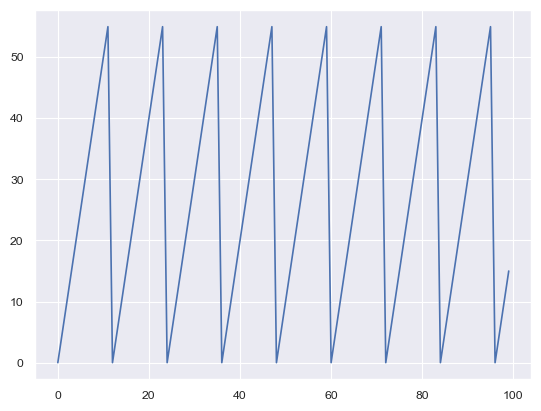

In [28]:
# Demonstrating the distribution of minutes prior to transformation
df[df['Name'] == 'CAPITL'].iloc[0:100]['Minute'].plot()

To Further demonstrate the problem we can look at a subsample of the data

In [40]:
df[df['Name'] == 'CAPITL'].iloc[10:14]

,Name,PTID,Load,Year,Month,Day,Minute,Hour,Max Temp,Min Temp,Max Wet Bulb,Min Wet Bulb
10,CAPITL,61757.0,1211.800049,2016,6,22,50,0,27.78,15.0,18.44,11.78
11,CAPITL,61757.0,1193.400024,2016,6,22,55,0,27.78,15.0,18.44,11.78
12,CAPITL,61757.0,1179.199951,2016,6,22,0,1,27.78,15.0,18.44,11.78
13,CAPITL,61757.0,1180.099976,2016,6,22,5,1,27.78,15.0,18.44,11.78


Looking at the 'Minute' column we can see that in, in reality, there are only 5 minute between 55 - 0, however an ML algorithm would assume this as 55 - 0 = 55 minutes difference. 

A common method for encoding cyclical data is to transform the data into two dimensions using a sine and consine transformation.

We can do that using the following transformations:


$$x_{sin} = sin(\frac{2*\pi*x}{max(x)}) $$
$$x_{cos} = cos(\frac{2*\pi*x}{max(x)}) $$

In [51]:
def encode_sin_cos(data:pd.DataFrame, col:str, max_val:Union[int, float]) -> pd.DataFrame:
    """Create two new columns within a given dataframe to encode specified cols with sin and cos transformations

    Args:
        data (pd.DataFrame): Dataframe containing cols to encode
        col (str): column to encode (month, yeah, minute etc)
        max_val (Union[int, float]): maximum value of the given column

    Returns:
        pd.DataFrame: original dataframe with additional columns
    """
    data[col + '_sin'] = np.sin(2 * np.pi * data[col]/max_val)
    data[col + '_cos'] = np.cos(2 * np.pi * data[col]/max_val)
    return data

In [53]:
df = encode_sin_cos(df, 'Month', df['Month'].max())
df = encode_sin_cos(df, 'Day', df['Day'].max())
df = encode_sin_cos(df, 'Minute', df['Minute'].max())
df = encode_sin_cos(df, 'Hour', df['Hour'].max())

In [54]:
df.head()

,Name,PTID,Load,Year,Month,Day,Minute,Hour,Max Temp,Min Temp,Max Wet Bulb,Min Wet Bulb,Month_sin,Month_cos,Day_sin,Day_cos,Minute_sin,Minute_cos,Hour_sin,Hour_cos
0,CAPITL,61757.0,1252.099976,2016,6,22,0,0,27.78,15.0,18.44,11.78,1.224647e-16,-1.0,-0.968077,-0.250653,0.000000,1.000000,0.0,1.0
1,CAPITL,61757.0,1239.199951,2016,6,22,5,0,27.78,15.0,18.44,11.78,1.224647e-16,-1.0,-0.968077,-0.250653,0.507666,0.861554,0.0,1.0
2,CAPITL,61757.0,1241.900024,2016,6,22,10,0,27.78,15.0,18.44,11.78,1.224647e-16,-1.0,-0.968077,-0.250653,0.874763,0.484551,0.0,1.0
3,CAPITL,61757.0,1240.900024,2016,6,22,15,0,27.78,15.0,18.44,11.78,1.224647e-16,-1.0,-0.968077,-0.250653,0.999646,-0.026621,0.0,1.0
4,CAPITL,61757.0,1226.900024,2016,6,22,20,0,27.78,15.0,18.44,11.78,1.224647e-16,-1.0,-0.968077,-0.250653,0.847734,-0.530421,0.0,1.0


Lets see what the newly transformed columns look like. 

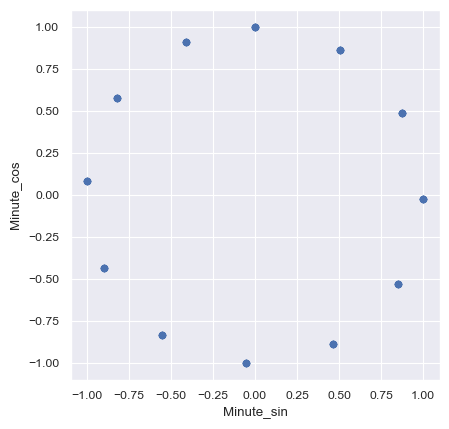

In [56]:
ax = df[df['Name'] == 'CAPITL'].iloc[0:100].plot.scatter('Minute_sin', 'Minute_cos').set_aspect('equal')

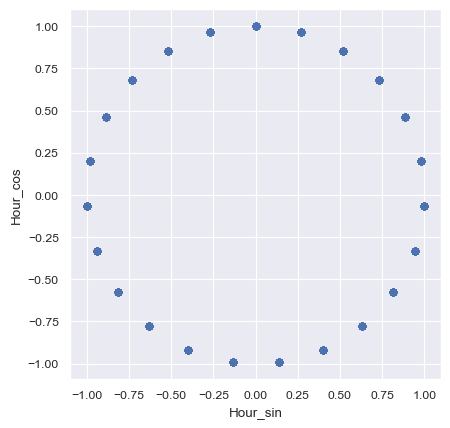

In [59]:
ax = df[df['Name'] == 'CAPITL'].plot.scatter('Hour_sin', 'Hour_cos').set_aspect('equal')

Exactly what we wanted, the data is now encoded as a cycle.